Votre mission

Dans cette activité, vous utiliserez la version régression du K-nn afin de prédire la qualité du vin. Vous évaluerez votre modèle à l’aide des méthodes étudiées dans cette partie pour optimiser votre algorithme et choisir les meilleurs hyper-paramètres (le nombre de voisins), à nouveau à l’aide d’une grid search, à implémenter vous même.

Objectif

Dans cette activité, vous devez optimiser l’erreur quadratique moyenne (Mean Squared Error, MSE). Vous pourrez observer le comportement de la MSE et la comparer à celui de R^2.

Vous comparerez les performances à l’aide d’une baseline naïve ainsi que les différentes heuristiques, comme effectué dans le TP précédent.  Pour cela, vous utiliserez cette fois le second dataset (https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv)

Livrable

Un classeur iPython où vous interpréterez les valeurs des différentes heuristiques utilisées ainsi que le choix final.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing, neighbors, metrics, dummy

In [2]:
data = pd.read_csv('winequality-red.csv', sep=";")
X = data.as_matrix(data.columns[:-1])
y = data.as_matrix([data.columns[-1]])
y = y.ravel()
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
# Séparation des données: 70% pour la validation croisée, 30% pour le test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

In [4]:
# Standardisation des features
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [5]:
# Grille des hyperparamètres
param_grid = {'n_neighbors': range(5,50)}

In [6]:
# On lance la validation croisée 
# On cherche à minimiser la MSE, le score qu'on choisit de maximiser est l'opposé de la MSE
regr = model_selection.GridSearchCV(neighbors.KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
regr.fit(X_train_std, y_train)
print(regr.best_params_)

{'n_neighbors': 10}


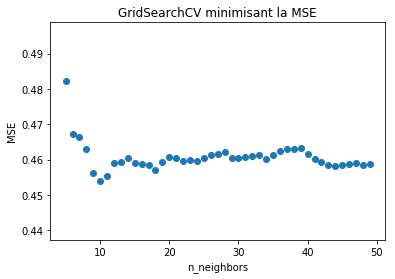

In [7]:
fig = plt.figure()
plt.title("GridSearchCV minimisant la MSE")
plt.xlabel("n_neighbors")
plt.ylabel("MSE")
plt.scatter(param_grid['n_neighbors'], np.abs(regr.cv_results_['mean_test_score']))
plt.show()

In [8]:
# On calcule la MSE et R^2 le test set
y_pred = regr.predict(X_test_std)
print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)} \n R2: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.41225 
 R2: 0.37452323253608677


In [9]:
# On étudie en parallèle la validation croisée qui minimise le MSE et celle qui maximise le R^2

In [10]:
scoring = {'MSE': 'neg_mean_squared_error', 'R2': 'r2'}
regr = model_selection.GridSearchCV(neighbors.KNeighborsRegressor(), param_grid, cv=5, scoring=scoring, refit='MSE')
regr.fit(X_train_std, y_train)
regr.best_params_

{'n_neighbors': 10}

/usr/lib/python3/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


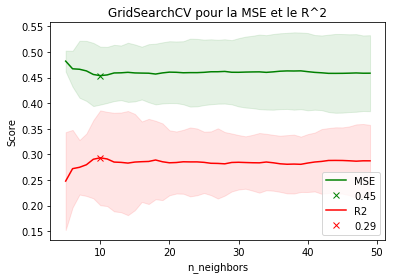

In [11]:
# Fortement inspiré de la doc de sklearn
fig = plt.figure()

plt.title("GridSearchCV pour la MSE et le R^2")

plt.xlabel("n_neighbors")
plt.ylabel("Score")

ax = plt.axes()

X_axis = np.array(regr.cv_results_['param_n_neighbors'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'r']):
    sample_score_mean = regr.cv_results_[f'mean_test_{scorer}']
    if scorer == 'MSE':
        sample_score_mean = np.abs(sample_score_mean)
    sample_score_std = regr.cv_results_[f'std_test_{scorer}']
    ax.fill_between(X_axis, sample_score_mean - 2 * sample_score_std,
                    sample_score_mean + 2 * sample_score_std,
                    alpha=0.1, color=color)
    ax.plot(X_axis, sample_score_mean, color=color,
            alpha=1,
            label=f"{scorer}")
    best_index = np.nonzero(regr.cv_results_['rank_test_%s' % scorer] == 1)[0][0]
    best_score = regr.cv_results_['mean_test_%s' % scorer][best_index]
    if scorer == 'MSE':
        best_score = np.abs(best_score)

    #ax.plot([X_axis[best_index], ] * 2, [0, best_score], linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)
    #ax.plot([X_axis[best_index], best_score], linestyle='-.', color=color, marker='x')
    #ax.annotate(f"{best_score:0.2f}", (X_axis[best_index], best_score + 0.005))
    ax.plot(X_axis[best_index], best_score,'ro',label=f"{best_score:0.2f}", color=color, marker='x')

ax.legend()
plt.show()

In [12]:
# On compare la MSE et le R^2 avec des baseline naïve

In [13]:
def regr_dummy(strat, **keywords):
    if strat == 'random':
        y_pred = np.random.randint(np.min(y), np.max(y), y_test.shape)
    else:
        regr = dummy.DummyRegressor(strat, **keywords)
        regr.fit(X_train_std, y_train)
        y_pred = regr.predict(X_test_std)
    print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)} \n R2: {metrics.r2_score(y_test, y_pred)}")

In [14]:
print('Knn avec n = {regr.best_params_}')
y_pred = regr.predict(X_test_std)
print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)} \n R2: {metrics.r2_score(y_test, y_pred)}")
for strat in ['mean', 'median', 'random']:
    print('\n Stratégie : '+strat)
    regr_dummy('mean')
from scipy.stats import mode
mod= mode(y, axis=0)
print('\n'+'Stratégie : mode')
regr_dummy('constant', constant=mod[0])

Knn avec n = {regr.best_params_}
MSE: 0.41225 
 R2: 0.37452323253608677

 Stratégie : mean
MSE: 0.6591622702671621 
 R2: -9.869264009454426e-05

 Stratégie : median
MSE: 0.6591622702671621 
 R2: -9.869264009454426e-05

 Stratégie : random
MSE: 0.6591622702671621 
 R2: -9.869264009454426e-05

Stratégie : mode
MSE: 1.0708333333333333 
 R2: -0.6246970814455803


In [15]:
print(f'''Conclusion :
La validation croisée nous donne un régresseur knn optimal au sens de la MSE pour {regr.best_params_}.
Comme attendu R^2 est d'autant meilleur que la MSE est petite.
Le régresseur obtenu a mieux appris que des régresseurs naïfs (prédiction aléatoire, prédiction constante égale 
à la moyenne, à la médiane, au mode. Ces régresseurs naïfs obtiennent de très mauvais scores (on obtient des R^2 négatifs).
Le modèle sélectionné avec un R^2 très inférieur à 1 apparait vraiment peu pertinent : la fraction de la variance
inexpliquée est très grande. 
''')

Conclusion :
La validation croisée nous donne un régresseur knn optimal au sens de la MSE pour {'n_neighbors': 10}.
Comme attendu R^2 est d'autant meilleur que la MSE est petite.
Le régresseur obtenu a mieux appris que des régresseurs naïfs (prédiction aléatoire, prédiction constante égale 
à la moyenne, à la médiane, au mode. Ces régresseurs naïfs obtiennent de très mauvais scores (on obtient des R^2 négatifs).
Le modèle sélectionné avec un R^2 très inférieur à 1 apparait vraiment peu pertinent : la fraction de la variance
inexpliquée est très grande. 

